# <center>**Trabajo Práctico Final**</center>

### <center>**Predicción de accidentes cerebrovasculares**</center>

#### <center>Aprendizaje de máquina - CEIA, Fiuba</center>

---

**Integrantes del grupo**

- Espínola, Carla
- Gambarte, Antonella
- Putrino, Daniela
- Silvera, Ricardo

---


## **Presentación**

El siguiente proyecto tiene como finalidad realizar un análisis comparativo de distintos modelos con el fin de predecir si una persona puede tener un acv o no. Para ello usaremos el Stroke Prediction Dataset disponible en Kaggle.

Link al dataset: [https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Se abordará el análisis exploratorio de los datos, su preprocesamiento y preparación, el empleo de distintos modelos para la predicción y la evaluación de los resultados obtenidos.


## **Análisis Exploratorio de Datos**

### Bibliotecas


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

### Carga de dataset


In [2]:
df_stroke = pd.read_csv("dataset/healthcare-dataset-stroke-data.csv")
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Cantidad de variables y observaciones


In [3]:
filas,columnas = df_stroke.shape
print(f"El DataFrame tiene {filas} observaciones y {columnas} variables.")

El DataFrame tiene 5110 observaciones y 12 variables.


In [4]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Primero eliminamos la columna id por tratarse de un identificador único que no aporta valor predictivo ni analítico.


In [5]:
df_stroke = df_stroke.drop(columns=['id'])

### Analizamos si hay duplicados y nulos


In [6]:
print("Cantidad de datos duplicados:", df_stroke.duplicated().sum())

Cantidad de datos duplicados: 0


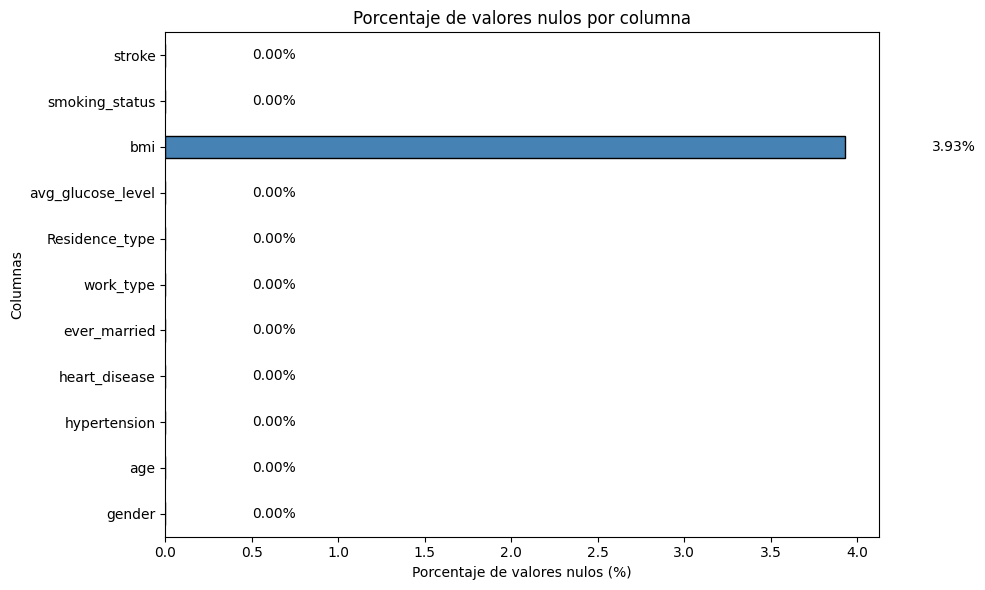

In [7]:
porcentaje_nulos = df_stroke.isna().mean().round(4) * 100

plt.figure(figsize=(10, 6))
porcentaje_nulos.plot(kind='barh', color='steelblue',edgecolor='black')

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

Como se observa, la única variable con valores nulos es la de bmi.

Vamos a hacer una comparativa de los faltantes respecto a distintos grupos etarios. Esta información nos va a servir en la etapa de preprocesamiento y preparación de datos para elegir el tratamientos adecuado.


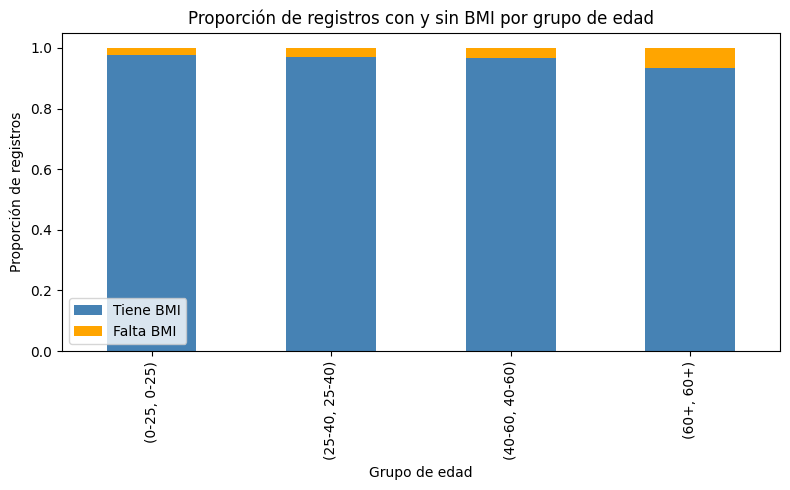

In [8]:
df_temp = df_stroke.copy()
df_temp["bmi_missing"] = df_temp["bmi"].isnull()

# Grupos de edad
bins = [0, 25, 40, 60, df_stroke["age"].max() + 1]
labels = ["0-25", "25-40", "40-60", "60+"]
df_temp["age_group"] = pd.cut(df_temp["age"], bins=bins, labels=labels, right=False)

# Calculamos proporciones dentro de cada grupo
prop_by_group = (
    df_temp.groupby(["age_group", "bmi_missing"], observed=True)
    .size()
    .groupby(level=0, observed=True)
    .apply(lambda x: x / x.sum())
    .unstack()
)

# Gráfico de barras apiladas
prop_by_group.plot(kind="bar", stacked=True, figsize=(8,5), color=["steelblue", "orange"])
plt.ylabel("Proporción de registros")
plt.xlabel("Grupo de edad")
plt.title("Proporción de registros con y sin BMI por grupo de edad")
plt.legend(["Tiene BMI", "Falta BMI"])
plt.tight_layout()
plt.show()

Observamos que los datos faltantes de BMI aumentan con la edad, por lo que se deduce que exite una dependencia de los faltantes con la edad.


### Estadísticas


In [9]:
df_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Para hypertension, heart_disease y el target stroke, se observa un desbalanceo. Analizaremos mirando los histogramas.


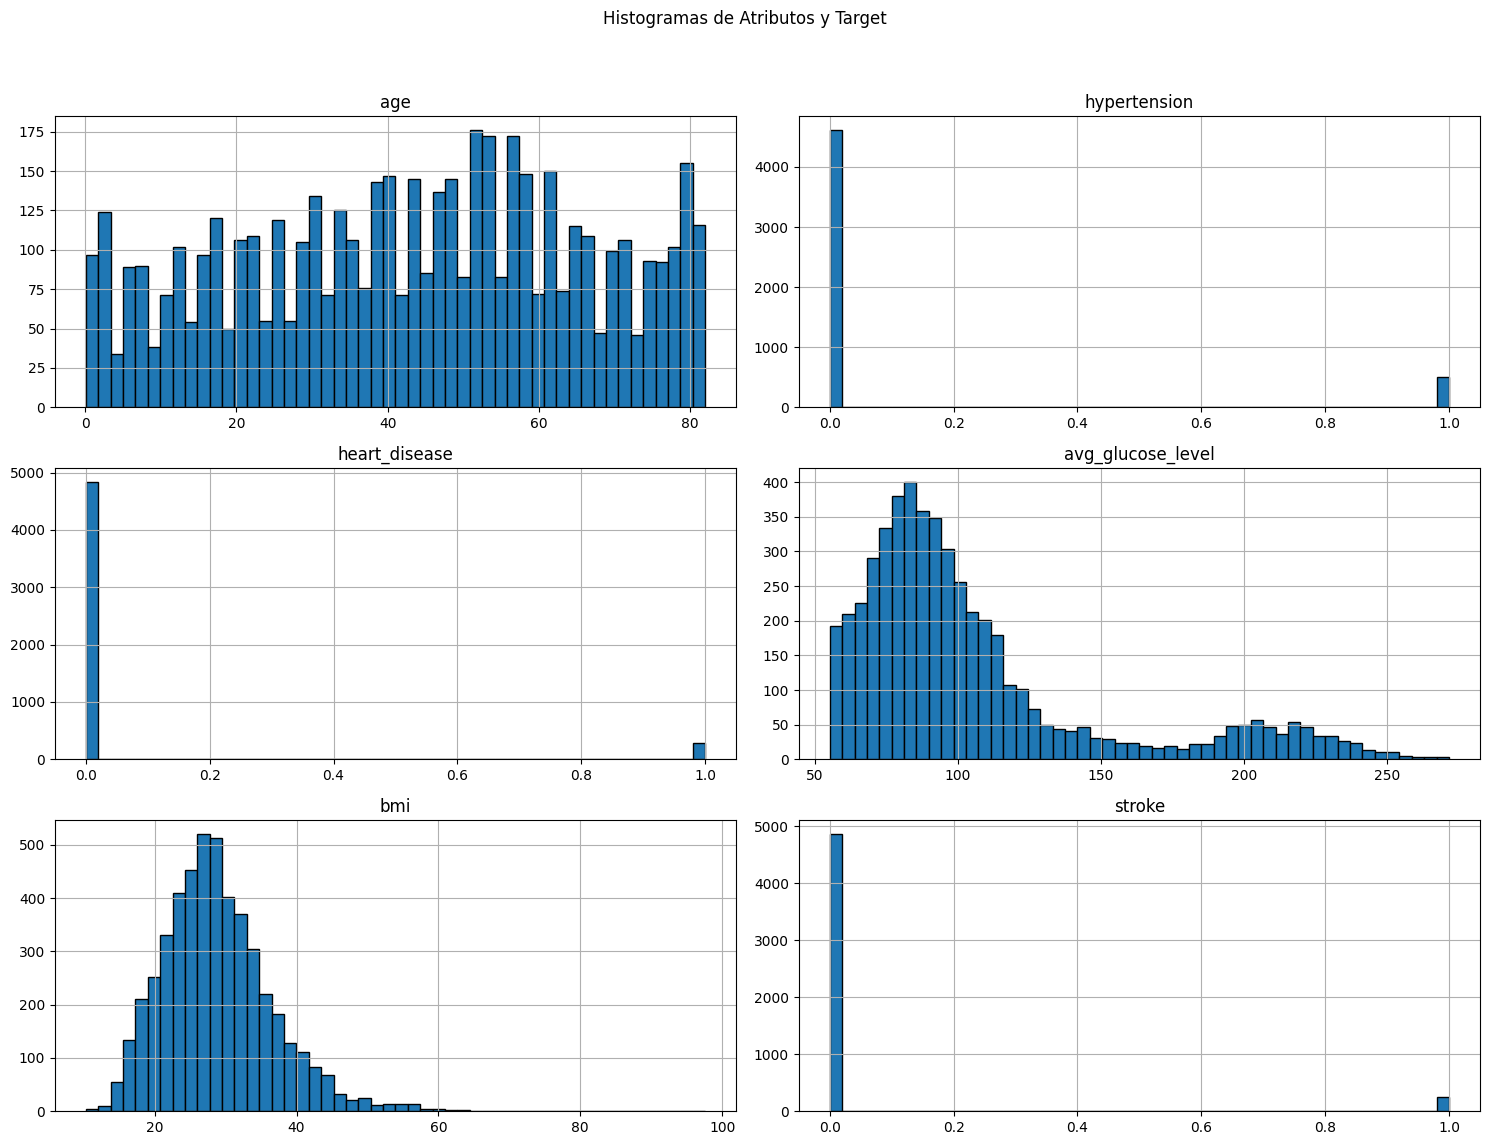

In [10]:
df_stroke.hist(figsize=(15, 12), bins=50, edgecolor='black')
plt.suptitle('Histogramas de Atributos y Target')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Claramente hypertension, heart_disease y el target stroke se encuentran muy desbalanceadas. En cuanto a avg_glucose_level tiene una distribución asimétrica positiva y BMI tiene una distribución más simétrica, con forma de campana (aproximadamente normal).

Vamos a analizar los valores altos que tienen bmi y avg_glucose_level para saber si contiene outliers o no.


{'avg_glucose_level': 627, 'bmi': 110}

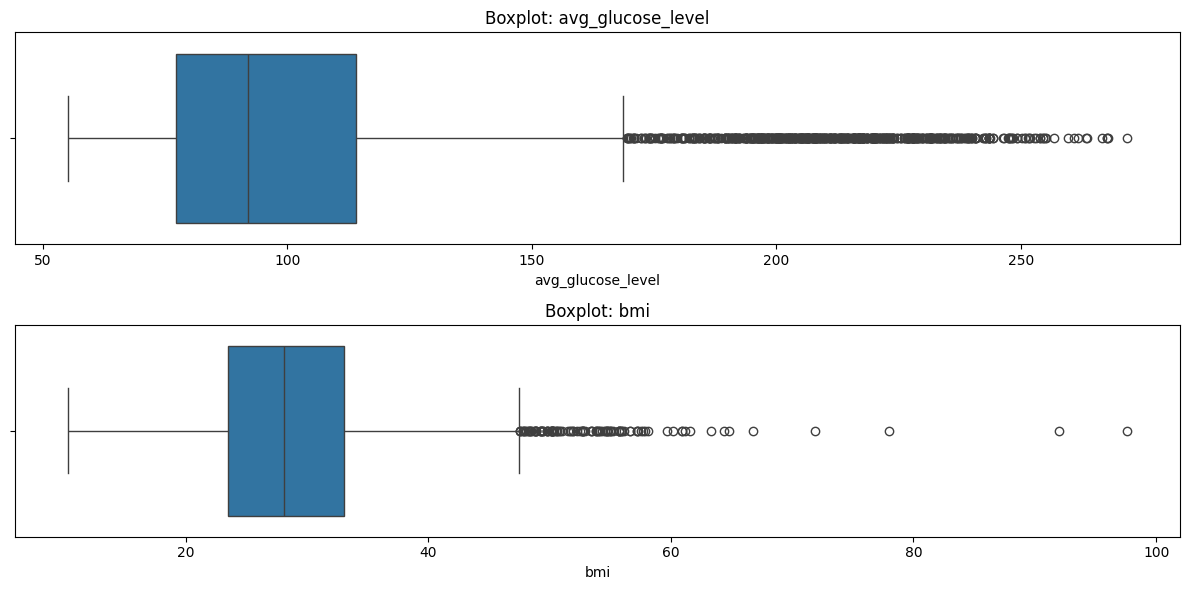

In [11]:
num_cols= ['avg_glucose_level','bmi']
outlier_summary = {}
plt.figure(figsize=(12, len(num_cols)*3))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=df_stroke[col])
    plt.title(f'Boxplot: {col}')
    q1 = df_stroke[col].quantile(0.25)
    q3 = df_stroke[col].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr
    outlier_summary[col] = int(((df_stroke[col] < lb) | (df_stroke[col] > ub)).sum())
plt.tight_layout()
outlier_summary

A primera vista existen muchos outliers. Vamos a hacer una comparativa de esas varibles con el target stroke, para saber si existe una relación entre los valores altos de glucosa y masa corporal con las personas que tuvieron acv.


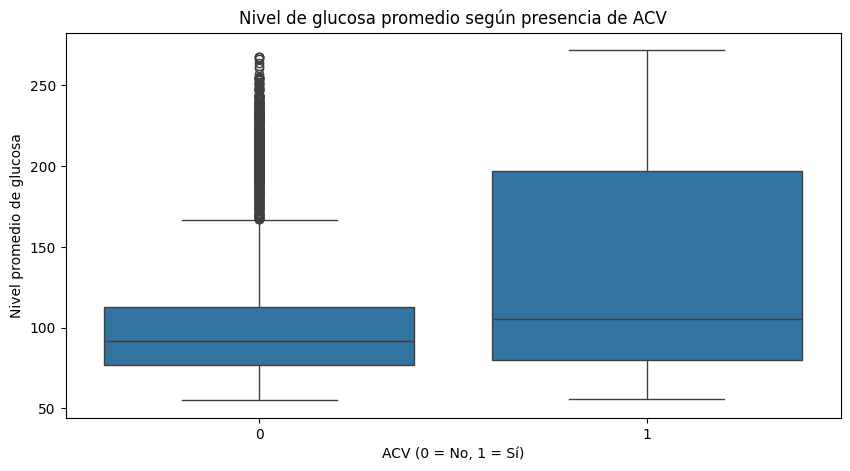

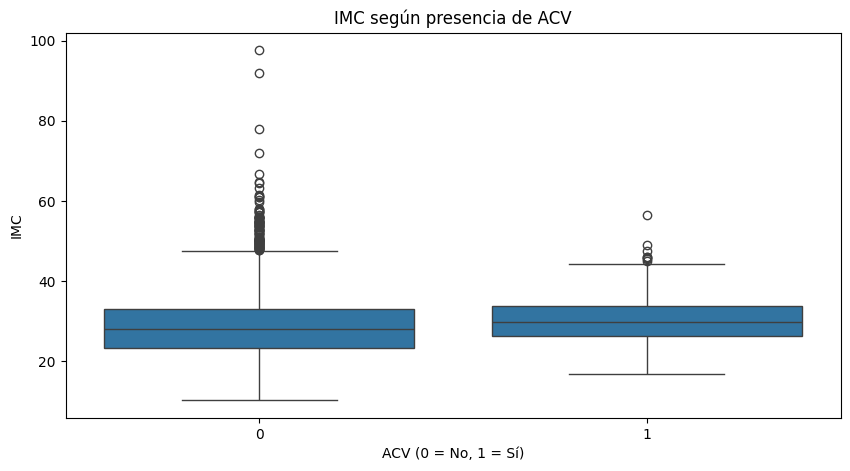

In [12]:
# Boxplot para glucosa
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_stroke, x='stroke', y='avg_glucose_level')
plt.title('Nivel de glucosa promedio según presencia de ACV')
plt.xlabel('ACV (0 = No, 1 = Sí)')
plt.ylabel('Nivel promedio de glucosa')
plt.show()

# Boxplot para BMI
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_stroke, x='stroke', y='bmi')
plt.title('IMC según presencia de ACV')
plt.xlabel('ACV (0 = No, 1 = Sí)')
plt.ylabel('IMC')
plt.show()

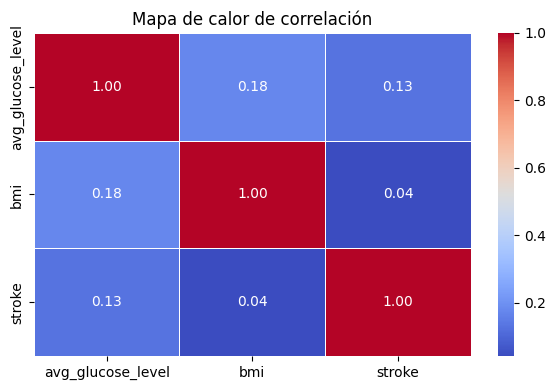

In [13]:
corr_matrix = df_stroke[['avg_glucose_level', 'bmi', 'stroke']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de calor de correlación')
plt.tight_layout()
plt.show()


Observando los gráficos anteriores vemos que el nivel de glucosa alto es la variable más relacionada con stroke, aunque su correlación es baja.
BMI apenas se relaciona con stroke.


Ahora empleamos la matriz de correlación para analizar las posibles relaciones entre las distintas varibles numéricas.


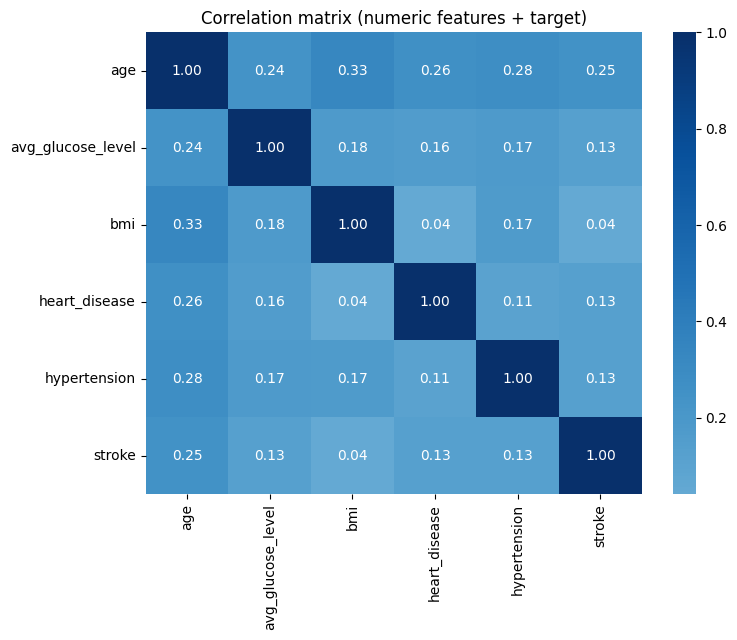

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64

In [14]:
num_cols = df_stroke.select_dtypes(include=['number']).columns.drop('stroke')
corr = df_stroke[num_cols.union(['stroke'])].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), center=0)
plt.title('Correlation matrix (numeric features + target)')
plt.show()

corr_with_target = corr['stroke'].sort_values(ascending=False)
corr_with_target

Vemos que la edad es factor más relacionado con la presencia de ACV, seguido por niveles de glucosa promedio, hipertensión y enfermedad cardíaca, aunque todas con correlaciones débiles. Por el contrario, el IMC no muestra una relación significativa con el ACV en esta muestra.

En términos generales, las variables numéricas no presentan alta colinealidad entre sí, lo que sugiere que pueden aportar información independiente en modelos predictivos.


### Análsis de variables categóricas


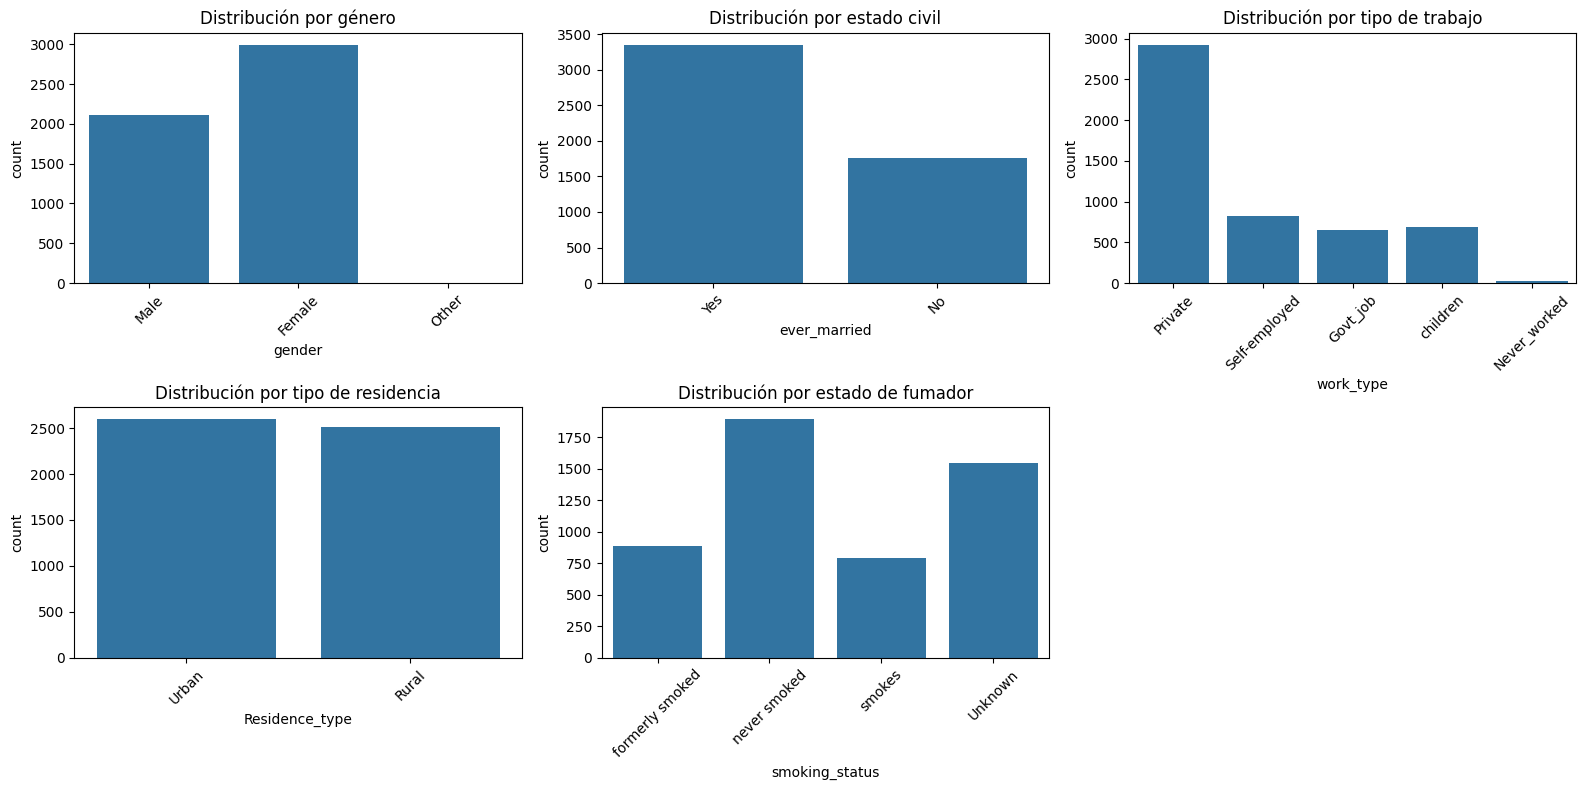

In [15]:
# Lista de columnas
cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
titles = ['Distribución por género', 'Distribución por estado civil', 'Distribución por tipo de trabajo', 
          'Distribución por tipo de residencia', 'Distribución por estado de fumador']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))  
axes = axes.flatten()

for i, (col, title) in enumerate(zip(cols, titles)):
    sns.countplot(data=df_stroke, x=col, ax=axes[i])
    axes[i].set_title(title)
    axes[i].tick_params(axis='x', rotation=45)

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Observaciones relevantes:

- Para género, existe una categoría "Other" que esta presente en una proporción pequeña.
- Para tipo de trabajo, también existe una categoría "Never worked" que esta presente en una pequeña proporción.
- En cuanto al estado civil, exite una desbalance, pero que consideramos aceptable.
- Para el estado del fumador, existe una categoría "Unknown" que, dado que tiene una cantidad considerable de datos si comparamos con las demás. Vamos a tratarla como una categoría más.


## **Preprocesamiento y Preparación de Datos**

Como primer paso, dividimos el dataset en train y test a fin de evitar el data leakage


In [16]:
X = df_stroke.drop("stroke", axis=1)
y = df_stroke["stroke"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Tratamiento de nulos

Dado que los faltantes en BMI representan sólo el 3.93% y como resultado del análisis de faltantes con respecto a la edad, decimos imputar los faltantes con la mediana por grupo de edad.


In [18]:
# Definimos grupos de edad
bins = [0, 25, 40, 60, df_stroke["age"].max() + 1]
labels = ["0–25", "25–40", "40–60", "60+"]

X_train["age_group"] = pd.cut(X_train["age"], bins=bins, labels=labels, right=False)
X_test["age_group"] = pd.cut(X_test["age"], bins=bins, labels=labels, right=False)

# Calculamos mediana de bmi por grupo solo en train
group_medians = X_train.groupby("age_group", observed=True)["bmi"].median()

# Función para imputar usando las medianas del train
def imputar_bmi(row):
    if pd.isnull(row["bmi"]):
        return group_medians.get(row["age_group"], X_train["bmi"].median())
    else:
        return row["bmi"]

# Aplicamos en train y test
X_train["bmi"] = X_train.apply(imputar_bmi, axis=1)
X_test["bmi"] = X_test.apply(imputar_bmi, axis=1)


X_train.drop(columns="age_group", inplace=True)
X_test.drop(columns="age_group", inplace=True)


### Outliers

Para BMI vamos a hacer una trasformación logarítmica para disminuir el impacto de los outliers.


In [19]:
X_train['bmi'] = np.log1p(X_train['bmi'])
X_test['bmi'] = np.log1p(X_test['bmi'])

PREGUNTA: Faltaría el nivel de glucosa. No se que sugieren que hagamos con eso. O se lo ve cuando hagamos los modelos.


### Variables categoricas

- Gender: Contamos cuantos hay por cada categoría.


In [20]:
df_stroke['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Como existe solo una fila con género "Other", decidimos fusionarlo con la categoría "Female" que es la que tiene más presencia y así minimizamos el impacto en la dispersión de datos.


In [21]:
print(X_train['gender'].value_counts())
print(X_test['gender'].value_counts())


gender
Female    2395
Male      1692
Other        1
Name: count, dtype: int64
gender
Female    599
Male      423
Name: count, dtype: int64


In [23]:
X_train['gender'] = X_train['gender'].replace('Other', 'Female')

Para codificar los datos usamos One-Hot Encoding


In [22]:
encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[['gender']])
X_test_encoded = encoder.transform(X_test[['gender']])

encoded_cols = encoder.get_feature_names_out(['gender'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

X_train = X_train.drop(columns=['gender']).join(X_train_encoded_df)
X_test = X_test.drop(columns=['gender']).join(X_test_encoded_df)


- Residence_type: aplicamos One-Hot Encoding


In [23]:

encoder_res = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_res = encoder_res.fit_transform(X_train[['Residence_type']])
X_test_encoded_res = encoder_res.transform(X_test[['Residence_type']])

encoded_cols_res = encoder_res.get_feature_names_out(['Residence_type'])
X_train_encoded_res_df = pd.DataFrame(X_train_encoded_res, columns=encoded_cols_res, index=X_train.index)
X_test_encoded_res_df = pd.DataFrame(X_test_encoded_res, columns=encoded_cols_res, index=X_test.index)

X_train = X_train.drop(columns=['Residence_type']).join(X_train_encoded_res_df)
X_test = X_test.drop(columns=['Residence_type']).join(X_test_encoded_res_df)


- ever_married: codificación manual donde Yes=1 y No=0


In [24]:
X_train['ever_married'] = X_train['ever_married'].map({'No': 0, 'Yes': 1})
X_test['ever_married'] = X_test['ever_married'].map({'No': 0, 'Yes': 1})

- smoking_status

PREGUNTA: Dejamos las 4?. o agrupamos "formerly smoked" y "smokes" por un lado y "never smoked" y "Unknown" por otro?. Mas que nada por la cantidad de columna que se generan


In [ ]:
X_train['smok']

In [25]:
encoder_smoke = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_smoke = encoder_smoke.fit_transform(X_train[['smoking_status']])
X_test_encoded_smoke = encoder_smoke.transform(X_test[['smoking_status']])

encoded_cols_smoke = encoder_smoke.get_feature_names_out(['smoking_status'])
X_train_encoded_smoke_df = pd.DataFrame(X_train_encoded_smoke, columns=encoded_cols_smoke, index=X_train.index)
X_test_encoded_smoke_df = pd.DataFrame(X_test_encoded_smoke, columns=encoded_cols_smoke, index=X_test.index)


X_train = X_train.drop(columns=['smoking_status']).join(X_train_encoded_smoke_df)
X_test = X_test.drop(columns=['smoking_status']).join(X_test_encoded_smoke_df)


- work_type: analizamos primero la cantidad de "Never_worked"


In [26]:
count_never_worked_train = (X_train['work_type'] == 'Never_worked').sum()
count_never_worked_test = (X_test['work_type'] == 'Never_worked').sum()

print(f"Never_worked en train: {count_never_worked_train}")
print(f"Never_worked en test: {count_never_worked_test}")


Never_worked en train: 13
Never_worked en test: 9


PREGUNTA: No se que les parece hacer esto a continuación?

No exiten muchos presentes. Optamos por unirlos a la categoría "Children" ya que esta es una categoría que indica que no trabaja activamente.


In [27]:
X_train['work_type'] = X_train['work_type'].replace('Never_worked', 'Children')
X_test['work_type'] = X_test['work_type'].replace('Never_worked', 'Children')

In [30]:
encoder_work = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_work = encoder_work.fit_transform(X_train[['work_type']])
X_test_encoded_work = encoder_work.transform(X_test[['work_type']])


encoded_cols_work = encoder_work.get_feature_names_out(['work_type'])
X_train_encoded_work_df = pd.DataFrame(X_train_encoded_work, columns=encoded_cols_work, index=X_train.index)
X_test_encoded_work_df = pd.DataFrame(X_test_encoded_work, columns=encoded_cols_work, index=X_test.index)


X_train = X_train.drop(columns=['work_type']).join(X_train_encoded_work_df)
X_test = X_test.drop(columns=['work_type']).join(X_test_encoded_work_df)


In [28]:
X_train.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
845,48.0,0,0,1,Private,69.21,3.529297,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3744,15.0,0,0,0,Private,122.25,3.091042,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4183,67.0,0,0,1,Self-employed,110.42,3.254243,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3409,44.0,0,0,1,Private,65.41,3.250374,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
284,14.0,0,0,0,Govt_job,82.34,3.484312,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## **Modelización**


## Árbol de Clasificación

Implementamos un modelo de Árbol de Clasificación, sabiendo a priori que este modelo no es recomendable cuando los datos de entrada están desbalanceados, como es nuestro caso, pero el motivo de esta decisión fue con fines experimentales que permitan comprobar en la práctica el comportamiento de este modelo en la situación planteada.

Desarrollamos una implementación desde cero, sin usar librerías que implementen el modelo, para ello definimos dos clases:

1) **Nodo**: Es el núcleo fundamental de este algoritmo y el que constituye la estructura básica del árbol de clasificación. Cada nodo puede ser:

- Un nodo de decisión (con feature, threshold, y nodos hijos left/right)

- Un nodo hoja (con value que representa la clase predicha)



2) **ArbolClasificacion**: Contiene la lógica codificada para la construcción del árbol de clasificación en base a los datos de entrada y los parámetros (entrenamiento) y metodos auxilizares para esta construcción y recuperación de la una predicción. Esta clase consiste en los siguientes métodos:
- init : El constructor de la clase, permite instanciar un árbol de clasificación y establecer los hiperparámetros:
    - max_depth: profundidad máxima del árbol

    - min_samples_split: número mínimo de muestras requeridas para dividir un nodo

    - criterio: métrica para evaluar la calidad de las divisiones (‘gini’ o ‘entropia’)
    
    - _gini/_entropia: Implementaciones de las métricas para evaluar las divisiones
    
    -  _best_split: Encuentra la mejor división posible para un nodo evaluando todos los posibles puntos de corte
    
    - _build_tree: Construye recursivamente el árbol hasta alcanzar las condiciones de parada
    
    - fit: Entrena el modelo con los datos de entrada y los targets
    
    - predict: Realiza predicciones para nuevas muestras
    
    - metricas (estático): Proporciona evaluación del modelo mediante:
        - Accuracy score
        - Matriz de confusión 
        - Reporte de clasificación 


Tambien incluimos condiciones de parada parametrizables:
- Alcanzar una profundidad máxima
- Tener menos muestras que min_samples_split


Este enfoque nos permite comprender en profundidad el funcionamiento interno de los árboles de decisión, sus ventajas y limitaciones, particularmente en escenarios con datos desbalanceados.


In [ ]:

class Nodo:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class ArbolClasificacion:
    def __init__(self, max_depth=3, min_samples_split=100, criterio='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        if criterio not in ['gini', 'entropia']:
            raise ValueError("El criterio debe ser 'gini' o 'entropia'")
        self.criterio = criterio
        self.root = None

    @staticmethod
    def metricas(y_test,y_pred):
        """
        Muestra metricas del resultado del entrenameonto.
        - Accuracy
        - Reporte de clasificación
        - Matriz de confisión
        
        Args:
            y_test : valores de prueba del target .
            y_pred : resultado de las clasificaciones del modelo.
        
        """
        from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
        # Evaluación del árbol de clasificación
        print('Métricas del Árbol de Clasificacion:')
        print('Accuracy:', accuracy_score(y_test, y_pred))
        print('\nReporte de clasificación:')
        print(classification_report(y_test, y_pred, digits=4))

                
        matriz = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Clasificación')
        plt.ylabel('Real')
        plt.title('Matriz de confusión - Árbol de Clasificacion')
        plt.show()

    def _gini(self, y):
        """
        Calcula el índice de Gini con los valores de y
        Args:
            y : valores sobre lso que se calcula el índice .
        
        """
        clases = np.unique(y)
        impurity = 1.0
        for c in clases:
            p = np.sum(y == c) / len(y)
            impurity -= p ** 2
        return impurity

    def _entropia(self, y):
        """
        Calcula el valor de la entropía de los datos en y

        Args:
            y: valores de sobre los que se calcula la entropía .
        """
        clases, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def _gain(self, y):
        if self.criterio == 'gini':
            return self._gini(y)
        else:
            return self._entropia(y)

    def _best_split(self, X, y):
        """
        Busca la mejor división posible de los datos en un nodo.

        Args:
            X: datos de entrada.
            y: etiquetas correspondientes.

        Returns:
            best_idx: índice de la feature que produce la mejor división.
            best_thr: valor umbral para esa feature.
        """
        best_score = np.inf if self.criterio == 'entropia' else 1
        best_idx, best_thr = None, None
        n_samples, n_features = X.shape
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                y_left = y[X[:, feature] <= t]
                y_right = y[X[:, feature] > t]
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                score = (len(y_left) * self._gain(y_left) + len(y_right) * self._gain(y_right)) / n_samples
                if (self.criterio == 'gini' and score < best_score) or (self.criterio == 'entropia' and score < best_score):
                    best_score = score
                    best_idx = feature
                    best_thr = t
        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        """
        Construye el arbol de clasificación

        Args:
            X: valores de feactures.
            y: valores de las etiquetas.
            depth: Profundidad máxiam del arbol.
        """
        
        #Condicion de parada: si todas las etiquetas son iguales o se cumple con la altura máxima o no se cumple con la cantidad minima de elementos
        if len(set(y)) == 1 or depth >= self.max_depth or len(y) < self.min_samples_split:
            value = np.bincount(y).argmax()
            return Nodo(value=value)
        #Realizar la mejor separación de los datos, se otiene el indice y el valor umbral para separar
        feature, threshold = self._best_split(X, y)

        # Si no se pudo separar
        if feature is None:
            value = np.bincount(y).argmax()
            return Nodo(value=value)
        
        idx_left = X[:, feature] <= threshold
        #llamado recursivo con los valores de de la rama izquierda
        left = self._build_tree(X[idx_left], y[idx_left], depth + 1)
        #llamado recursivo con los valores de de la rama derecha
        right = self._build_tree(X[~idx_left], y[~idx_left], depth + 1)
        return Nodo(feature, threshold, left, right)

    def fit(self, X, y):
        """
        Entrena el modelo

        Args:
            X: valores de feactures de entrenamiento.
            y: valores de las etiquetas de entrenamiento.
        """
        self.root = self._build_tree(np.array(X), np.array(y), 0)

    def _predict_one(self, x, node):
        """
        Realiza la clasificación para una muestra
        
        Args:
            x: valores de feactures de una muestra.
            nodo: nodo del arbol para navegar hasta la solución.
        """
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        """
        Realiza la predicción para los datos en X
        
        Args:
            X: valores de feactures para clasificar.
            nodo: nodo del arbol para navegar hasta la solución.
        """
        return np.array([self._predict_one(x, self.root) for x in np.array(X)])
    

Elegimos entrenar el árbol de clasificación utilizando el criterio de entropía porque este mide la pureza de los nodos considerando la cantidad de información necesaria para clasificar correctamente las muestras. Si bien también implementamos el criterio Gini, en conjuntos de datos desbalanceados como el nuestro, la entropía es más adecuada ya que es más sensible a la presencia de clases minoritarias. Esto permite que el árbol favorezca divisiones que ayuden a identificar mejor los casos menos frecuentes, en lugar de priorizar únicamente la clase mayoritaria. Así, el uso de entropía contribuye a obtener un modelo más equilibrado en términos de sensibilidad y especificidad.

![image.png](attachment:image.png)

Entrenaos el modelo y mostramos los resultados obtenidos

Métricas del Árbol de Decisión:
Accuracy: 0.949119373776908

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9510    0.9979    0.9739       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9491      1022
   macro avg     0.4755    0.4990    0.4869      1022
weighted avg     0.9045    0.9491    0.9262      1022



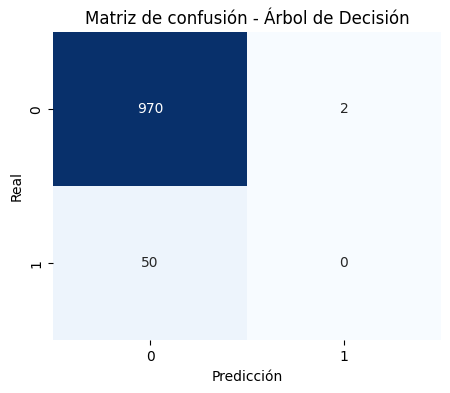

In [34]:
arbol_entropia = ArbolClasificacion(max_depth=3, criterio='entropia')
arbol_entropia.fit(X_train, y_train)
y_pred_entropia = arbol_entropia.predict(X_test)

ArbolClasificacion.metricas(y_test, y_pred_entropia)

El resultado muestra una **accuracy** de 0.95, lo que se podría mal interpretar como un excelente desempeño. Pero al analizar los otros indicadores se observa que:
- Para la clase 1 (ACV), tanto la precisión como el recall son 0.00, es decir, el modelo no logra identificar ningún caso positivo correctamente.
- El **f1-score** para la clase 1 también es 0.00, lo que confirma que el modelo no es útil para detectar la ocurrencia de ACV.

Esto se debe al gran desbalance de clase que existe en el dataset. A continuación vamos a  aplicar una técnica de balanceo de clases para mejorar la sensibilidad hacia la clase minoritaria.

#### Oversampling

Utilizamos la clase RanmOverSampler de la librería imblearn para generar muestras sintéticas y disminuir los efectos del desbalance de clases en el entrenamiento del modelo y analizar los resultados.

In [32]:
# Aplicamos sobremuestreo solo al dataset de entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print('Distribución original:', y_train.value_counts().to_dict())
print('Distribución balanceada:', y_train_bal.value_counts().to_dict())


Distribución original: {0: 3889, 1: 199}
Distribución balanceada: {np.int64(0): np.int64(3889), np.int64(1): np.int64(3889)}


Métricas del Árbol de Decisión:
Accuracy: 0.7592954990215264

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9853    0.7582    0.8570       972
           1     0.1423    0.7800    0.2407        50

    accuracy                         0.7593      1022
   macro avg     0.5638    0.7691    0.5489      1022
weighted avg     0.9441    0.7593    0.8268      1022



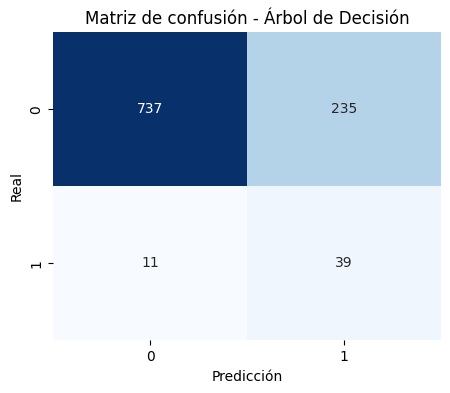

In [33]:
# Entrenar árbol sobre datos balanceados
arbol_entropia_bal = ArbolClasificacion(max_depth=3, criterio='entropia')
arbol_entropia_bal.fit(X_train_bal, y_train_bal)
y_pred_entropia_bal = arbol_entropia_bal.predict(X_test)

ArbolClasificacion.metricas(y_test, y_pred_entropia_bal)

## **Evaluación de Resultados**
